In [1]:
#%pip install tensorflow[and-cuda]
#%pip install matplotlib
#%pip install -q kaggle
#%pip install python-dotenv
#%pip install opencv-python
#%pip install pydot
#%pip install pyyaml h5py

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

2024-01-21 00:50:45.611053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 00:50:45.611106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 00:50:45.657008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 00:50:45.757651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 00:50:46.784935: W tensorflow/compiler/tf2

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-01-21 00:50:48.328580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:48.507746: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:48.507923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


The following step loads the images from the dataset.

It also deletes the images that are corrupted or that don't actually exist. 

Problem: This results in an imbalanced dataset since there could be more corrupted images that correspond to a class or to another.

Solution: Leave it be or remove the corresponding ID in the other class (e.g. if the image from class Fire with id 100 is removed, the image id 100 Non Fire will be also removed)

It is also important to verify if there are corrupt images in the testing dataset. If there are any, they also need to be removed.

In [4]:
from dataset import download_dataset
from dataset import display_dataset_images


download_bool = False
display_bool = False
if download_bool:
    download_dataset()

if display_bool:
    display_dataset_images()

In [5]:
TRAIN_DATA_DIR = '../datasets/Data/Train_Data/'
TEST_DATA_DIR = '../datasets/Data/Test_Data/'
IMG_HEIGHT = 224 # Max size allowed for MobileNetV2
IMG_WIDTH = 224 # Max size allowed for MobileNetV2
SEED = 123
BATCH_SIZE = 8
CHANNELS = 3

from dataset import prepare_datasets
train_ds, val_ds, test_ds = prepare_datasets(TRAIN_DATA_DIR, TEST_DATA_DIR, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED)

Found 4609 files belonging to 2 classes.
Using 3688 files for training.


2024-01-21 00:50:56.464677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:56.465243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:56.465564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:56.756217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 00:50:56.756535: I external/local_xla/xla/stream_executor

Found 4609 files belonging to 2 classes.
Using 921 files for validation.
Found 50 files belonging to 2 classes.


In [6]:
from forest_fire_model import mobile_net_transfer_learning, mobile_net_transfer_learning, forest_fire_model, predict_fire

base_model, preprocess_input = mobile_net_transfer_learning(IMG_HEIGHT, IMG_WIDTH, CHANNELS, train_ds)
model = forest_fire_model(preprocess_input, base_model, train_ds, val_ds, test_ds, load=True, path='feature_extraction_model.h5')

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

2024-01-21 00:51:07.578378: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


(8, 7, 7, 1280)


In [7]:
# Positive values predict class 1 -> Non Fire
# Negative values predict class 0 -> Fire
y_hat = model.predict(test_ds)
y_hat[y_hat > 0] = 1
y_hat[y_hat < 0] = 0

7/7 [==============================] - 3s 133ms/step


1/1 [==============================] - 0s 19ms/step


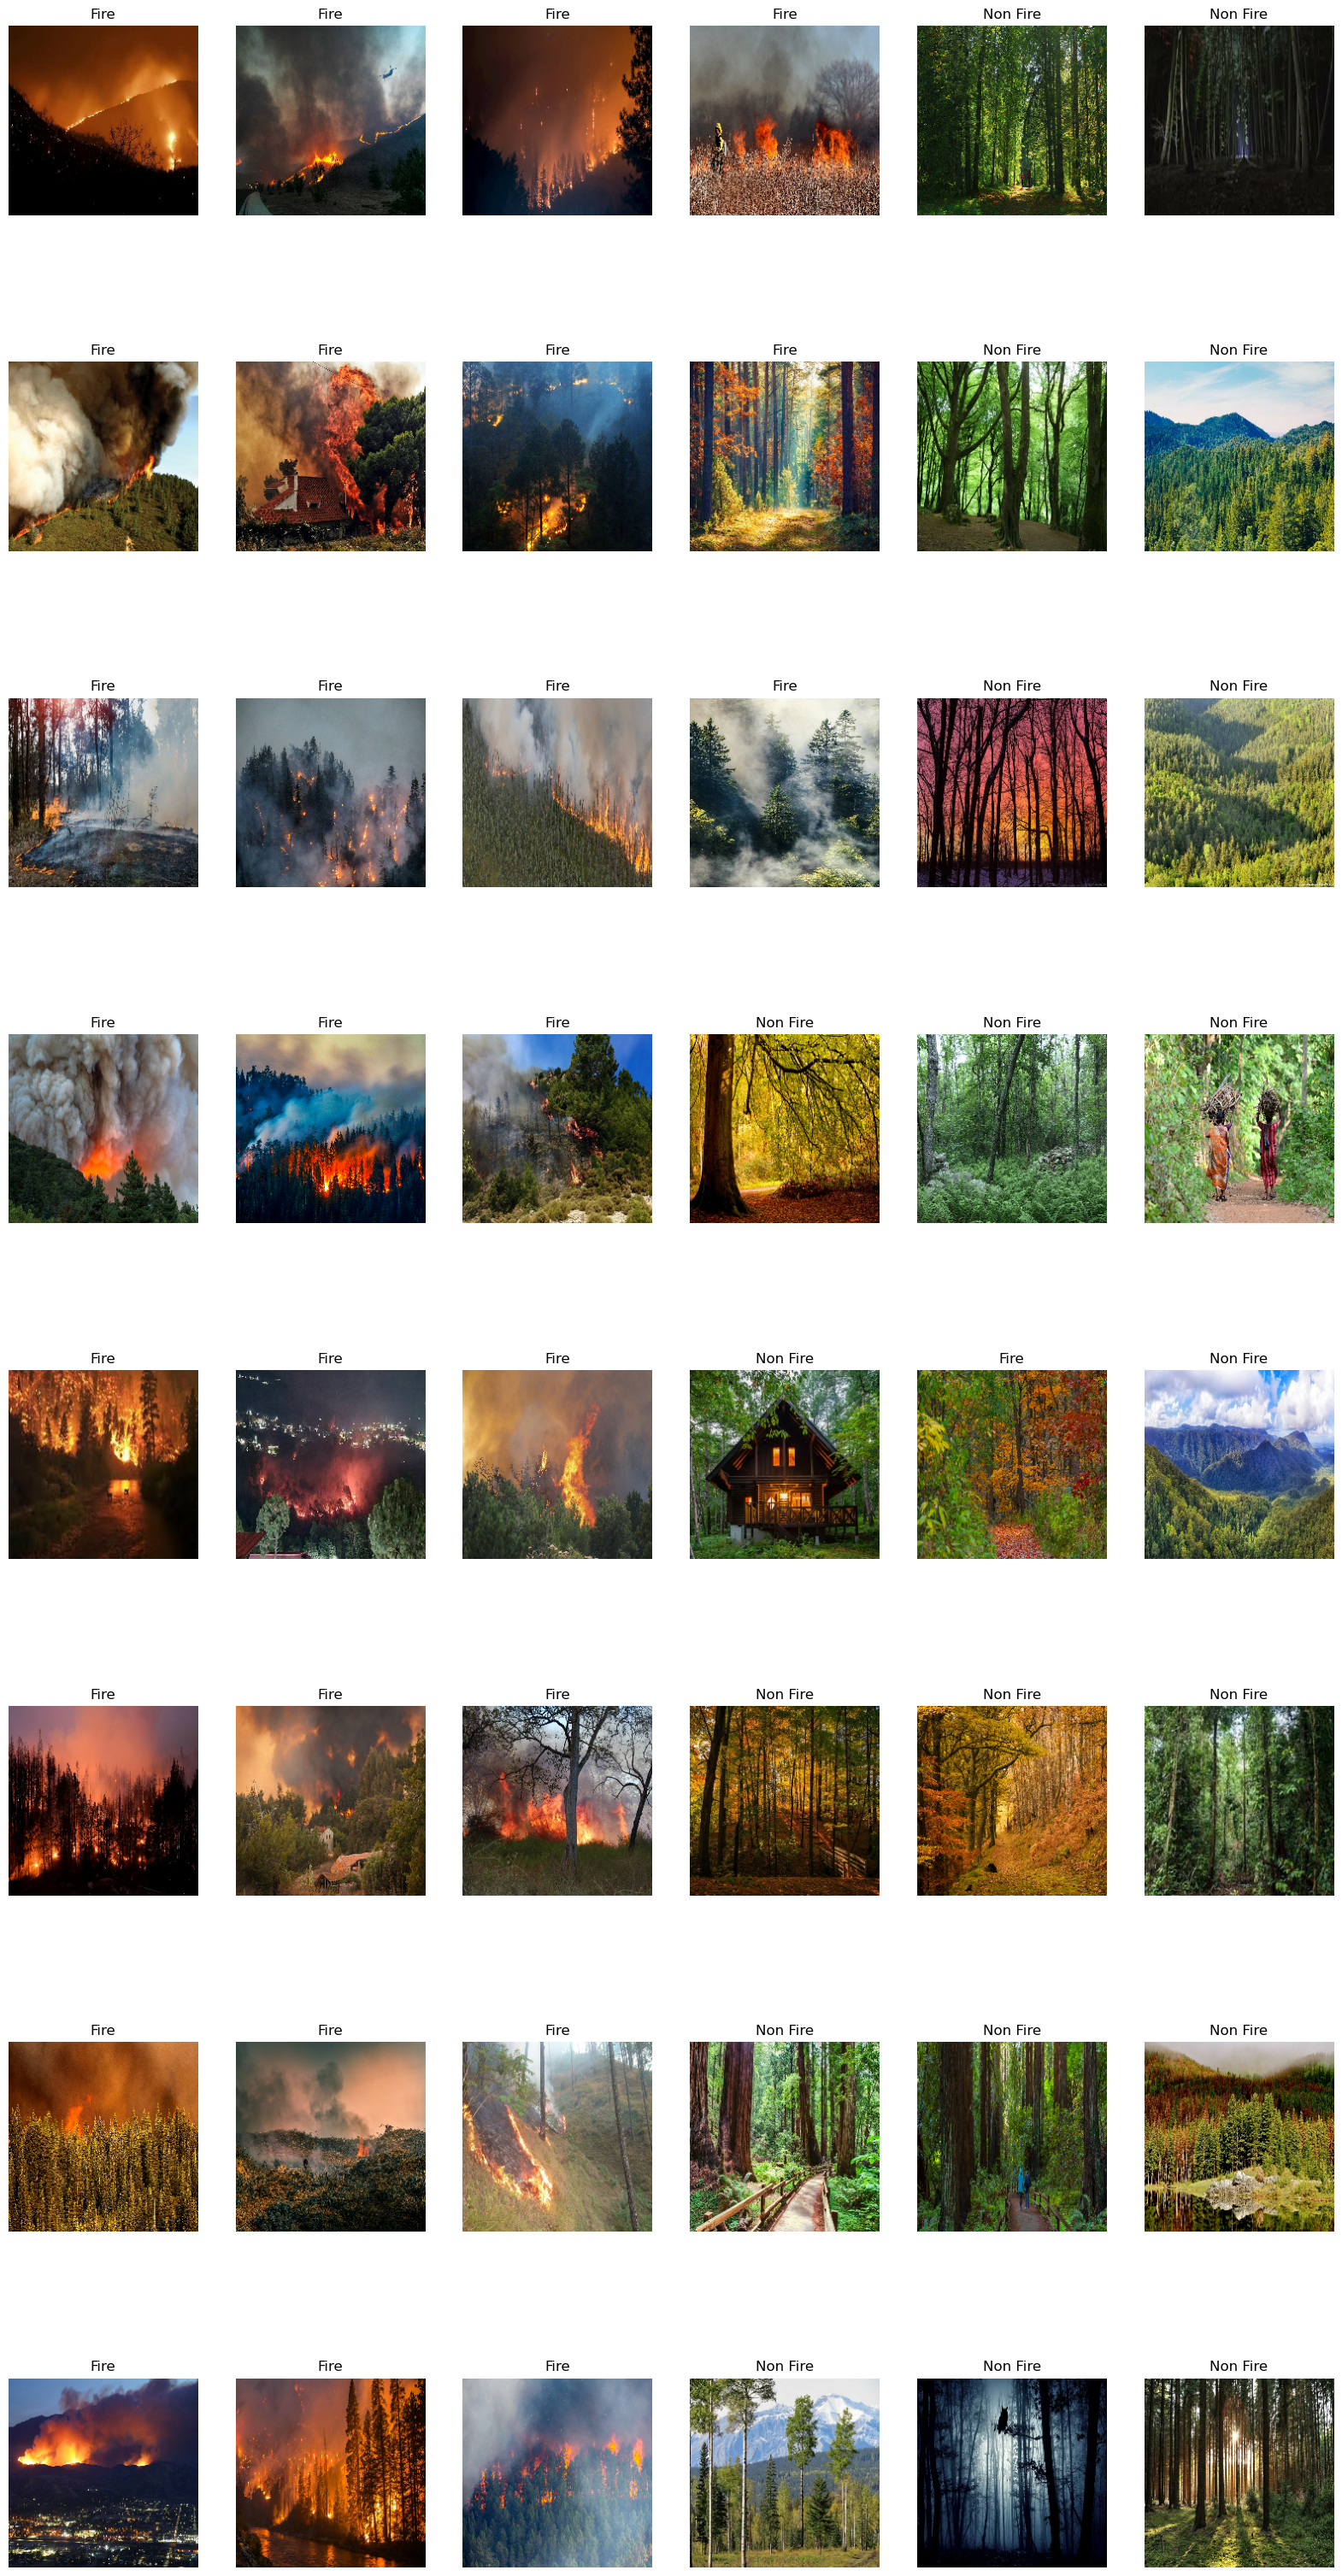

In [23]:
fig, ax = plt.subplots(nrows=8, ncols=6, figsize=(20, 40))
j = 0
for batch_x, batch_y in test_ds:
    if j==6:
        break
    predicted_batch = predict_fire(model, batch_x)
    # print(predicted_batch)
    for i, x in enumerate(batch_x):
        ax[i, j].imshow(x.numpy().astype("uint8"))
        ax[i, j].axis("off")
        predicted_label = predicted_batch[i][0]
        ax[i, j].set_title(f'{predicted_label}')
    j+=1
plt.show()

In [28]:
from video_labeling import video_to_frames

input_loc = 'Wildfires_101_National_Geographic.mp4'
output_loc = 'frames/'

video_to_frames(input_loc, output_loc, model)

Number of frames:  5767
Converting video..

1/1 [==============================] - 0s 20ms/step
Non Fire
1/1 [==============================] - 0s 19ms/step
Non Fire
1/1 [==============================] - 0s 18ms/step
Fire
1/1 [==============================] - 0s 25ms/step
Fire
1/1 [==============================] - 0s 19ms/step
Fire
1/1 [==============================] - 0s 22ms/step
Fire
1/1 [==============================] - 0s 26ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================] - 0s 18ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================] - 0s 18ms/step
Fire
1/1 [==============================] - 0s 19ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================] - 0s 20ms/step
Fire
1/1 [==============================]